<a href="https://colab.research.google.com/github/Drime648/Lit-Summarizer/blob/main/Skim_Lit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-19edb329-5a75-231e-7f47-a744da49d4be)


#Get the Data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [ ]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# !cat /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

#Preprocessing

In [ ]:
def get_lines(filename):
  with open(filename) as f:
    return f.readlines()

  

In [ ]:
train_lines = get_lines(data_dir + "train.txt")

In [ ]:
##train_lines[:10]

How this data should look like:
```
[
  { line_number: 1,
    label: 'OBJECTIVE',
    text: 'BLAH BLAH',
    total_lines: 10,
    line_num: 5},
  {...}
]
  ```



In [ ]:
def preprocess_lines(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_num, abstract_line in enumerate(abstract_line_split):
        line_data = {}

        split_text = abstract_line.split("\t")

        line_data["label"] = split_text[0]
        line_data["text"] = split_text[1].lower()
        line_data["line_num"] = abstract_line_num
        line_data["total_lines"] = len(abstract_line_split) - 1

        abstract_samples.append(line_data)
    else:
      abstract_lines += line

    
  return abstract_samples




In [ ]:
train_data_samples = preprocess_lines(data_dir + "train.txt")
test_data_samples = preprocess_lines(data_dir + "test.txt")
val_data_samples = preprocess_lines(data_dir + "dev.txt")

In [ ]:
train_data_samples

[{'label': 'OBJECTIVE',
  'line_num': 0,
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'label': 'METHODS',
  'line_num': 1,
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'label': 'METHODS',
  'line_num': 2,
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'label': 'METHODS',
  'line_num': 3,
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'label': 'METHODS',
  'line_num': 4,
  'text': 'secondary outcome measures included the western ontari

# Visualize Data

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame(train_data_samples)
val_df = pd.DataFrame(val_data_samples)
test_df = pd.DataFrame(test_data_samples)

In [ ]:
train_df.head(20)

,label,text,line_num,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_text = train_df["text"].tolist()
train_labels = train_df["label"].to_numpy()
val_text = val_df["text"].tolist()
val_labels = val_df["label"].to_numpy()

test_text = test_df["text"].tolist()
test_labels = test_df["label"].to_numpy()

In [ ]:
train_text[:5], train_labels[:5]

(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'],
 array(['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'METHODS'],
       dtype=object))

# Labels to Numbers

##One Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
one_hot_train_labels = one_hot_encoder.fit_transform(train_df["label"].to_numpy().reshape(-1,1))
one_hot_val_labels = one_hot_encoder.transform(val_df["label"].to_numpy().reshape(-1,1))
one_hot_test_labels = one_hot_encoder.transform(test_df["label"].to_numpy().reshape(-1,1))

In [ ]:
one_hot_train_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
tf.constant(one_hot_train_labels), tf.constant(one_hot_val_labels), tf.constant(one_hot_test_labels)

(<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>,
 <tf.Tensor: shape=(30212, 5), dtype=float64, numpy=
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>,
 <tf.Tensor: shape=(30135, 5), dtype=float64, numpy=
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]])>)

##Encode Labels to Ints

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
encoded_train_labels = label_encoder.fit_transform(train_df["label"].to_numpy())
encoded_val_labels = label_encoder.transform(val_df["label"].to_numpy())
encoded_test_labels = label_encoder.transform(test_df["label"].to_numpy())

In [ ]:
tf.constant(encoded_train_labels), tf.constant(encoded_val_labels), tf.constant(encoded_test_labels)

(<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 1, 1])>,
 <tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>,
 <tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 4, 4, ..., 4, 4, 1])>)

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [ ]:
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Make Baseline Naive Bayes Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()),
  ("clf", MultinomialNB()),
])

In [ ]:
model_0.fit(train_text, encoded_train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
baseline_score = model_0.score(test_text, encoded_test_labels)

In [ ]:
baseline_score

0.716674962667994

#Prepare text into numbers


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
text_lengths = [len(sentence.split()) for sentence in train_text]

In [ ]:
avg_text_len = np.round(avg_text_len)

In [ ]:
avg_text_len

26.0

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <a list of 10 Patch objects>)

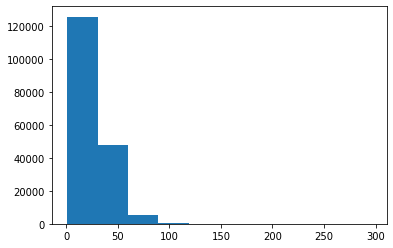

In [ ]:
import matplotlib.pyplot as plt

plt.hist(text_lengths, 10)

##Text Vectorizer

In [ ]:
max_vocab = 68000
max_len = 55

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_vocab, output_sequence_length=max_len)

In [ ]:
text_vectorizer.adapt(train_text)

In [ ]:
import random

sen = random.choice(train_text)
print(sen)

vect_sen = text_vectorizer([sen])
print(vect_sen)



positive effects of securing methadone via the trial , included self-reported improvements in health and self-care ; reduction in crime , stress and drug use .
tf.Tensor(
[[  280    71     4 14478  4640   598     2    32   121   799   408     5
     97     3  2833   169     5 26978   401     3   300    87     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)


In [ ]:
vocab_20k_len = len(text_vectorizer.get_vocabulary())

##Embedding Layer

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
embedding_layer = Embedding(vocab_20k_len, 128, mask_zero=True, name = "embedding_layer")

In [ ]:
embed_sen = embedding_layer(vect_sen)
embed_sen

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.01299249,  0.03880385, -0.01619674, ..., -0.01438427,
          0.04835025, -0.04269817],
        [ 0.04578365, -0.00937856,  0.02491171, ...,  0.01677079,
          0.01903513, -0.01857153],
        [-0.02760508, -0.0407243 , -0.0091882 , ...,  0.03301037,
          0.0299197 ,  0.00032129],
        ...,
        [-0.04432613,  0.00366106,  0.04436154, ...,  0.00814805,
          0.03353376, -0.0410458 ],
        [-0.04432613,  0.00366106,  0.04436154, ...,  0.00814805,
          0.03353376, -0.0410458 ],
        [-0.04432613,  0.00366106,  0.04436154, ...,  0.00814805,
          0.03353376, -0.0410458 ]]], dtype=float32)>

#Efficient Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, one_hot_train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, one_hot_val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, one_hot_test_labels))



train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, val_dataset, test_dataset

(<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>)

#Make Model 1

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
embeds = embedding_layer(text_vectors)

x = layers.Conv1D(128, 3, padding = "same", activation="relu")(embeds)
x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name = "Model_1")

model_1.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "Model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 55, 128)           49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
Total params: 8,349,573
Trainable params: 8,349,573
Non-trainable params: 0
_________________________________________________

In [ ]:
history_1 = model_1.fit(train_dataset, epochs = 10, steps_per_epoch=int(0.1 * len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps= int(0.2 * len(val_dataset)))

#10 epochs gives 80.44% accuracy

Epoch 1/10
562/562 [==============================] - 46s 81ms/step - loss: 0.8224 - accuracy: 0.6900 - val_loss: 0.5925 - val_accuracy: 0.7814
Epoch 2/10
562/562 [==============================] - 46s 82ms/step - loss: 0.5851 - accuracy: 0.7889 - val_loss: 0.5402 - val_accuracy: 0.7966
Epoch 3/10
562/562 [==============================] - 46s 83ms/step - loss: 0.5513 - accuracy: 0.7989 - val_loss: 0.5151 - val_accuracy: 0.8105
Epoch 4/10
562/562 [==============================] - 47s 83ms/step - loss: 0.5273 - accuracy: 0.8099 - val_loss: 0.5074 - val_accuracy: 0.8087
Epoch 5/10
424/562 [=====================>........] - ETA: 11s - loss: 0.5310 - accuracy: 0.8045

KeyboardInterrupt: ignored

In [ ]:
# model_1.evaluate(test_dataset)

#Pre-trained embedding layer

In [ ]:
import tensorflow_hub as hub

In [ ]:
embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False, name = "encoder")

In [ ]:
embeddings = embed_layer([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)


tf.Tensor(
[[-0.03133019 -0.06338634 -0.016075   ... -0.0324278  -0.0457574
   0.05370456]
 [ 0.05080859 -0.01652432  0.01573778 ...  0.00976658  0.0317012
   0.01788116]], shape=(2, 512), dtype=float32)


#Model 2

In [ ]:
inputs = layers.Input(shape = [], dtype = tf.string)

embeds = embed_layer(inputs)

x = layers.Reshape((1, 512))(embeds)

x = layers.Conv1D(128, 3, padding = "same", activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name = "Model_2")

model_2.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

In [ ]:
model_2.summary()

Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
encoder (KerasLayer)         (None, 512)               256797824 
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 512)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            196736    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 256,995,205
Trainable params: 197,381
Non-trainable params: 256,797,824
_______________________________________

In [ ]:
history_2 = model_2.fit(train_dataset, epochs = 5, steps_per_epoch=int(0.1 * len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps= int(0.1 * len(val_dataset)))


Epoch 1/5
562/562 [==============================] - 38s 14ms/step - loss: 0.9084 - accuracy: 0.6556 - val_loss: 0.7955 - val_accuracy: 0.6902
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7697 - accuracy: 0.7001 - val_loss: 0.7570 - val_accuracy: 0.7048
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7548 - accuracy: 0.7105 - val_loss: 0.7433 - val_accuracy: 0.7131
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7229 - accuracy: 0.7216 - val_loss: 0.7165 - val_accuracy: 0.7257
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7310 - accuracy: 0.7191 - val_loss: 0.6961 - val_accuracy: 0.7354


In [ ]:
# model_2.evaluate(test_dataset)

#Character Embeddings

##Character Tokenizer

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_chars(line) for line in train_text]
val_chars = [split_chars(line) for line in val_text]
test_chars = [split_chars(line) for line in test_text]

In [ ]:
train_chars[:10]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
char_lengths = [len(char) for char in train_text]
avg_char_len = np.mean(char_lengths)

In [ ]:
cover_most_chars = int(np.percentile(char_lengths, 95))

In [ ]:
cover_most_chars

290

In [ ]:
import string
alph = string.ascii_lowercase + string.digits + string.punctuation
num_char_tokens = len(alph) + 2
num_char_tokens

70

In [ ]:
char_vectorizer = TextVectorization(num_char_tokens, output_sequence_length=cover_most_chars, name = "char_vectorizing_layer")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_len_vocab = len(char_vectorizer.get_vocabulary())

##Character Embedding

In [ ]:
char_embedding_layer = Embedding(char_len_vocab, 25, mask_zero=True, name = "char_embedding_layer")

In [ ]:
sample_chars_vect = char_vectorizer([split_chars(sen)])

In [ ]:
sample_chars_embed = char_embedding_layer(sample_chars_vect)

In [ ]:
sample_chars_vect, sample_chars_embed

(<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
 array([[20,  2, 16,  9,  2, 10,  3, 13,  2,  9,  2, 10,  5,  3,  5,  3,
          7,  4, 10,  2,  6,  3,  4, 17, 19,  2,  9,  9,  2,  6,  3,  4,
          5, 12,  6,  2, 20, 22,  7,  8,  6, 11,  5,  8,  2, 14,  8,  5,
         11,  3,  4, 11,  2,  9,  5,  9, 10,  2, 17,  4,  6,  2, 10, 22,
         19,  3, 13,  2, 20,  7,  8, 12, 10, 13,  2,  5, 12,  3, 13,  7,
          8, 18,  5,  6,  4, 25,  5,  3,  4,  7,  6,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  

#Make Model 3

In [ ]:
char_train_dataset = tf.data.Dataset.from_tensor_slices((train_chars, one_hot_train_labels))
char_val_dataset = tf.data.Dataset.from_tensor_slices((val_chars, one_hot_val_labels))
char_test_dataset = tf.data.Dataset.from_tensor_slices((test_chars, one_hot_test_labels))



char_train_dataset = char_train_dataset.batch(32)
char_train_dataset = char_train_dataset.prefetch(tf.data.AUTOTUNE)

char_val_dataset = char_val_dataset.batch(32)
char_val_dataset = char_val_dataset.prefetch(tf.data.AUTOTUNE)

char_test_dataset = char_test_dataset.batch(32)
char_test_dataset = char_test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
char_train_dataset, train_dataset

(<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>)

In [ ]:
# inputs = layers.Input(shape = (1,), dtype = tf.string)
# char_vectors = char_vectorizer(inputs)
# char_embeds = char_embedding_layer(char_vectors)

# x = layers.Conv1D(128, 5, padding = "same", activation="relu")(char_embeds)
# x = layers.GlobalMaxPooling1D()(x)

# outputs = layers.Dense(num_classes, activation="softmax")(x)

# model_3 = tf.keras.Model(inputs, outputs, name = "Model_3")

# model_3.compile(loss = "categorical_crossentropy",
#                 optimizer = "Adam",
#                 metrics = ["accuracy"])

In [ ]:
# model_3.summary()

In [ ]:
# history_3 = model_3.fit(char_train_dataset, epochs = 10, steps_per_epoch=int(0.1 * len(char_train_dataset)),
#                         validation_data=char_val_dataset,
#                         validation_steps= int(0.2 * len(char_val_dataset)))

In [ ]:
# model_3.evaluate(char_test_dataset)

#Model 4: Character + Token Embeddings

In [ ]:
# #token model
# token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
# token_embeds = embed_layer(token_inputs)
# token_outputs = layers.Dense(128, activation = "relu")(token_embeds)

# token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# #char model

# char_inputs = layers.Input(shape = (1,), dtype = tf.string)
# char_vectors = char_vectorizer(char_inputs)
# char_embeds = char_embedding_layer(char_vectors)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeds)

# char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

# #concatenate both models
# token_char_concat = layers.Concatenate(name = "hybrid")([token_model.output, char_model.output])

# hybrid_dropout = layers.Dropout(0.5)(token_char_concat)
# hybrid_dense = layers.Dense(128, activation = "relu")(hybrid_dropout)
# end_dropout = layers.Dropout(0.5)(hybrid_dense)
# output = layers.Dense(num_classes, activation = "softmax")(end_dropout)

# #combine everything

# model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
#                          outputs = output,
#                          name = "Model_4")

In [ ]:
# model_4.summary()

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model_4, show_shapes = True)

In [ ]:

# model_4.compile(loss = "categorical_crossentropy",
#                 optimizer = "SGD",
#                 metrics = ["accuracy"])

##Efficient Hybrid Datasets

In [ ]:
hybrid_train_data = tf.data.Dataset.from_tensor_slices((train_text, train_chars))
hybrid_train_labels = tf.data.Dataset.from_tensor_slices(one_hot_train_labels)
hybrid_train_dataset = tf.data.Dataset.zip((hybrid_train_data, hybrid_train_labels))

hybrid_train_dataset = hybrid_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
hybrid_train_dataset


<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [ ]:
hybrid_val_data = tf.data.Dataset.from_tensor_slices((val_text, val_chars))
hybrid_val_labels = tf.data.Dataset.from_tensor_slices(one_hot_val_labels)
hybrid_val_dataset = tf.data.Dataset.zip((hybrid_val_data, hybrid_val_labels))

hybrid_val_dataset = hybrid_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
hybrid_val_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [ ]:
hybrid_test_data = tf.data.Dataset.from_tensor_slices((test_text, test_chars))
hybrid_test_labels = tf.data.Dataset.from_tensor_slices(one_hot_test_labels)
hybrid_test_dataset = tf.data.Dataset.zip((hybrid_test_data, hybrid_test_labels))

hybrid_test_dataset = hybrid_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
hybrid_test_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

##Fit model 4

In [ ]:
# history_4 = model_4.fit(hybrid_train_dataset, epochs = 3, steps_per_epoch=int(0.1 * len(hybrid_train_dataset)),
#                         validation_data=hybrid_val_dataset,
#                         validation_steps= int(0.2 * len(hybrid_val_dataset)))

#Positional Embedding

In [ ]:
train_df[:20]

,label,text,line_num,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_line_nums = tf.one_hot(train_df["line_num"].to_numpy(), depth = 15)
val_line_nums = tf.one_hot(val_df["line_num"].to_numpy(), depth = 15)
test_line_nums = tf.one_hot(test_df["line_num"].to_numpy(), depth = 15)

train_line_nums[:5], val_line_nums[:5], test_line_nums[:5]

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.,

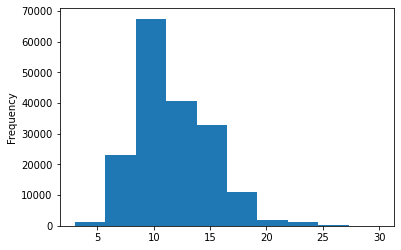

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_total_lines = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

In [ ]:
train_total_lines[:1], val_total_lines[:2], test_total_lines[:2]

(<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>)

#Model 5: Character + Token + Positional Embeddings

In [ ]:
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_inputs")
token_embeddings = embed_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

In [ ]:
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding_layer(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [ ]:
line_num_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = "line_num_inputs")
line_num_outputs = layers.Dense(32, activation = "relu")(line_num_inputs)
line_num_model = tf.keras.Model(line_num_inputs, line_num_outputs)

In [ ]:
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_inputs")
total_lines_outputs = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

In [ ]:
combined_embeddings = layers.Concatenate(name = "first_concat")([token_model.output, char_model.output])

In [ ]:
combined_dense = layers.Dense(256, activation = "relu")(combined_embeddings)
first_dropout = layers.Dropout(0.5)(combined_dense)

In [ ]:
tribrid_combination_embeddings = layers.Concatenate(name = "tribrid_concat")([line_num_model.output, total_lines_model.output, first_dropout])

In [ ]:
tribrid_output_layer = layers.Dense(5, activation="softmax", name = "tribrid_output_layer")(tribrid_combination_embeddings)

In [ ]:
model_5 = tf.keras.Model(inputs = [line_num_model.input, total_lines_model.input, token_model.input, char_model.input],
                         outputs = tribrid_output_layer)

In [ ]:
model_5.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizing_layer (TextVec (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
encoder (KerasLayer)            (None, 512)          256797824   token_inputs[0][0]               
___________________________________________________________________________________________

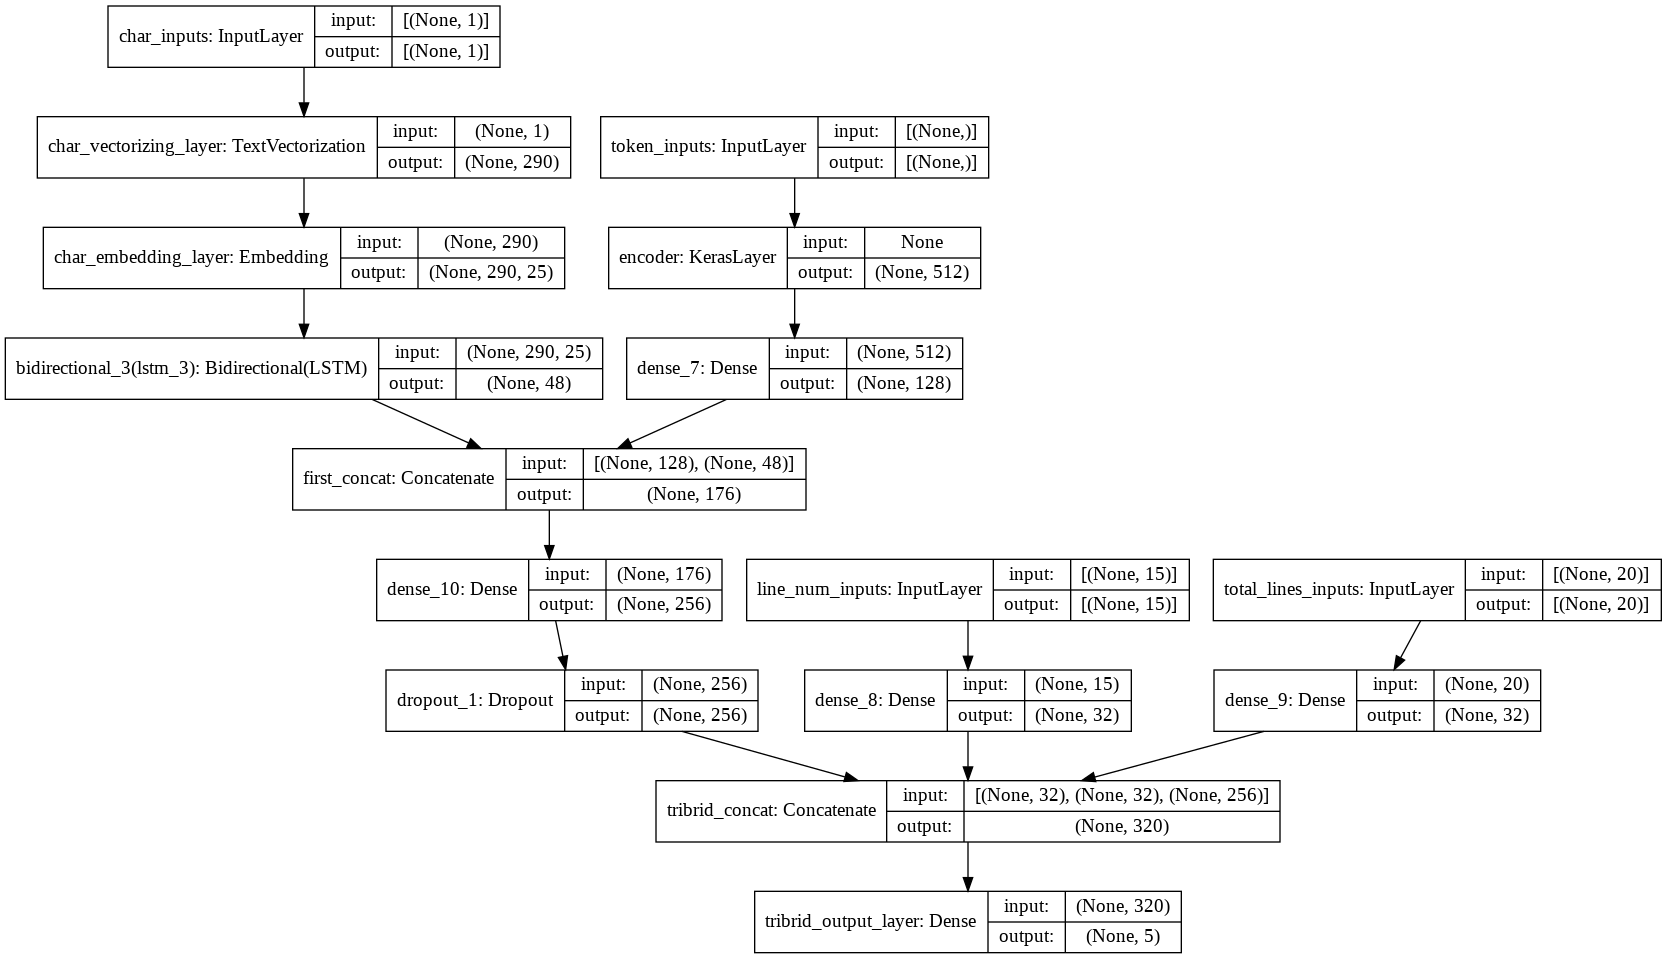

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes = True)

In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

##Tribrid Dataset

In [ ]:
tribrid_train_data = tf.data.Dataset.from_tensor_slices((train_line_nums, train_total_lines, train_text, train_chars))
tribrid_train_labels = tf.data.Dataset.from_tensor_slices(one_hot_train_labels)
tribrid_train_dataset = tf.data.Dataset.zip((tribrid_train_data, tribrid_train_labels))

tribrid_train_dataset = tribrid_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
tribrid_train_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
tribrid_val_data = tf.data.Dataset.from_tensor_slices((val_line_nums, val_total_lines, val_text, val_chars))
tribrid_val_labels = tf.data.Dataset.from_tensor_slices(one_hot_val_labels)
tribrid_val_dataset = tf.data.Dataset.zip((tribrid_val_data, tribrid_val_labels))

tribrid_val_dataset = tribrid_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
tribrid_val_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
tribrid_test_data = tf.data.Dataset.from_tensor_slices((test_line_nums, test_total_lines, test_text, test_chars))
tribrid_test_labels = tf.data.Dataset.from_tensor_slices(one_hot_test_labels)
tribrid_test_dataset = tf.data.Dataset.zip((tribrid_test_data, tribrid_test_labels))

tribrid_test_dataset = tribrid_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
tribrid_test_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

##Fit data

In [ ]:
history_5 = model_5.fit(tribrid_train_dataset, epochs = 3, steps_per_epoch=int(0.1 * len(tribrid_train_dataset)),
                        validation_data=tribrid_val_dataset,
                        validation_steps= int(0.1 * len(tribrid_val_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 51ms/step - loss: 1.0999 - accuracy: 0.7188 - val_loss: 0.9816 - val_accuracy: 0.8039
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9662 - accuracy: 0.8141 - val_loss: 0.9490 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9503 - accuracy: 0.8235 - val_loss: 0.9409 - val_accuracy: 0.8288


In [ ]:
model_5.evaluate(tribrid_test_dataset)
#82.81% on test, 83.01% on val after 3 epochs!!!

942/942 [==============================] - 21s 23ms/step - loss: 0.9465 - accuracy: 0.8278


[0.9464548826217651, 0.8278082013130188]

# Scale up the model

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

FileNotFoundError: ignored